In [11]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit

np.random.seed(7)
sns.set()
plt.rcParams['figure.figsize']=(9,4)

In [12]:
n=500
dates=pd.bdate_range('2021-01-01', periods=n)
mu = np.where(np.arange(n)<n//2, 0.0003, -0.0001)
sigma = np.where(np.arange(n)<n//2, 0.01, 0.015)
eps = np.random.normal(mu, sigma)
jumps = np.zeros(n); jump_days = np.random.choice(np.arange(20,n-20), size=5, replace=False)
jumps[jump_days] = np.random.normal(0,0.05,size=len(jump_days))
rets = eps + jumps
price = 100*np.exp(np.cumsum(rets))
df = pd.DataFrame({'price':price}, index=dates)
df['ret'] = df['price'].pct_change().fillna(0.0)
df['log_ret'] = np.log1p(df['ret'])
df.head()

,price,ret,log_ret
2021-01-01,101.735412,0.000000,0.000000
2021-01-04,101.292875,-0.004350,-0.004359
2021-01-05,101.356527,0.000628,0.000628
2021-01-06,101.800950,0.004385,0.004375
2021-01-07,101.031283,-0.007561,-0.007589


In [13]:
df['lag_1'] = df['ret'].shift(1)
df['roll_mean_5'] = df['ret'].rolling(5).mean().shift(1)
df['roll_vol_20'] = df['ret'].rolling(20).std().shift(1)
df['y_next_ret'] = df['ret'].shift(-1)
df['y_up'] = (df['y_next_ret']>0).astype(int)
df_feat = df.dropna().copy()
df_feat.head()

,price,ret,log_ret,lag_1,roll_mean_5,roll_vol_20,y_next_ret,y_up
2021-01-29,100.198878,0.016949,0.016807,-0.014854,-0.003707,0.007370,0.001845,1
2021-02-01,100.383751,0.001845,0.001843,0.016949,0.002509,0.008455,-0.003565,0
2021-02-02,100.025880,-0.003565,-0.003571,0.001845,0.001706,0.008429,0.020804,1
2021-02-03,102.106835,0.020804,0.020591,-0.003565,0.000685,0.008453,-0.000154,0
2021-02-04,102.091126,-0.000154,-0.000154,0.020804,0.004236,0.009675,-0.014106,0


In [14]:

cut = int(len(df_feat)*0.8)
train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]

features = ['lag_1','roll_mean_5','roll_vol_20'] 
X_tr, X_te = train[features], test[features]
y_tr_reg, y_te_reg = train['y_next_ret'], test['y_next_ret']


In [15]:

reg = Pipeline([
    ('scaler', StandardScaler()), 
    ('linreg', LinearRegression())
])
reg.fit(X_tr, y_tr_reg)
pred = reg.predict(X_te)

rmse = mean_squared_error(y_te_reg, pred) ** 0.5
mae = mean_absolute_error(y_te_reg, pred)
print(f'MAE: {mae:.6f}, RMSE: {rmse:.6f}')


MAE: 0.011540, RMSE: 0.014445


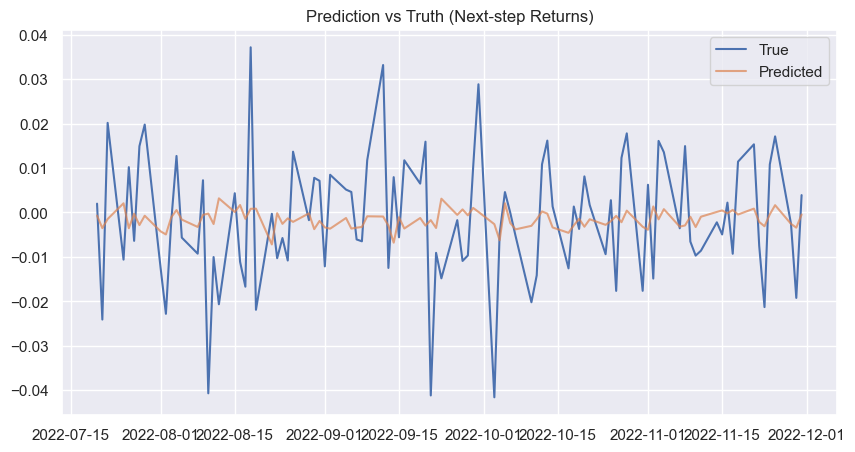

In [16]:
plt.figure(figsize=(10,5))
plt.plot(y_te_reg.index, y_te_reg, label='True')
plt.plot(y_te_reg.index, pred, label='Predicted', alpha=0.7)
plt.legend()
plt.title('Prediction vs Truth (Next-step Returns)')
plt.show()



- **Feature Engineering**  
  We created lag and rolling mean features to capture short-term memory in returns.   

- **Model Performance**  
  The Linear Regression baseline shows limited predictive power (MAE and RMSE are small but not zero).   

- **What works and fails**  
  Lag features add useful information about direction.The model cannot capture volatility clusters and jump shocks, since it is purely linear.  
  
- **Next Steps**  
  We can Try some additional rolling volatility features, non-linear models (tree-based), or models tailored for time series (ARIMA, LSTM). 

